In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from sensr import calc_sensitive_directions, compl_svd_projector, unprotected_direction, train_fair_model
from sensr import normalize_sensitive_directions, sample_perturbation, sample_perturbation, fair_dist

from models import MLP
from training import train_classifier

In [2]:
def plot_decision(model, x, y):
    plot_step = 0.02
    X = x.cpu().numpy()
    Y = y.cpu().numpy()
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(
        np.arange(x_min, x_max, plot_step), np.arange(y_min, y_max, plot_step)
    )
    plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)
    
    xs = np.c_[xx.ravel(), yy.ravel()]
    Z = model(torch.FloatTensor(xs)).detach().cpu().numpy()[:,1]
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=plt.cm.RdYlBu)
    plt.scatter(X[:,0], X[:,1], c=Y)

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
def gen_synth_data(ds_size=6000):
    pr_priv_fav=0.3
    pr_unpriv_fav=1 - pr_priv_fav
    
    n_priv_fav = int((ds_size//2) * pr_priv_fav)
    n_unpriv_fav =int((ds_size//2) * pr_unpriv_fav)
    n_priv_unfav = int((ds_size//2) * (1-pr_priv_fav))
    n_unpriv_unfav = int((ds_size//2) * (1-pr_unpriv_fav))
  
    x_priv_fav = torch.cat([torch.normal(mean=2, std=1, size=(n_priv_fav, 1)), torch.normal(mean=1, std=0.02, size=(n_priv_fav, 1))], dim=1)
    x_unpriv_fav = torch.cat([torch.normal(mean=2, std=1, size=(n_unpriv_fav, 1)), torch.normal(mean=0, std=0.02, size=(n_unpriv_fav, 1))], dim=1)
    
    x_priv_unfav = torch.cat([torch.normal(mean=0, std=1, size=(n_priv_unfav, 1)), torch.normal(mean=1, std=0.02, size=(n_priv_unfav, 1))], dim=1)
    x_unpriv_unfav = torch.cat([torch.normal(mean=0, std=1, size=(n_unpriv_unfav, 1)), torch.normal(mean=0, std=0.02, size=(n_unpriv_unfav, 1))], dim=1)
    
    synth_inputs = torch.cat((x_priv_fav, x_unpriv_fav, x_priv_unfav, x_unpriv_unfav), dim=0)
    synth_labels = torch.cat( (torch.ones(n_priv_fav + n_unpriv_fav), torch.zeros(n_priv_unfav + n_unpriv_unfav)), dim=0)
    synth_metas = torch.cat( (torch.ones(n_priv_fav), torch.zeros(n_unpriv_fav), torch.ones(n_priv_unfav), torch.zeros(n_unpriv_unfav)), dim=0)
    
    return synth_inputs, synth_labels, synth_metas

In [5]:
x, y, s = gen_synth_data()

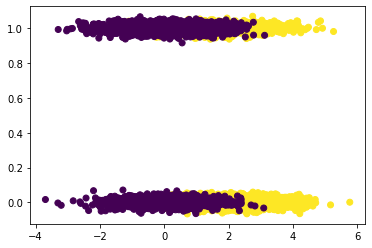

In [6]:
plt.scatter(x[:,0], x[:,1], c=y)

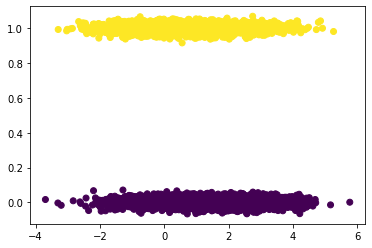

In [7]:
plt.scatter(x[:,0], x[:,1], c=s)

In [8]:
sensitive_directions = calc_sensitive_directions(x.numpy(), s.numpy())
sensitive_directions

array([[-0.21250947, 15.28449754]])

In [9]:
sensitive_directions_ = normalize_sensitive_directions(sensitive_directions.T)
sensitive_directions_

array([[ 1.93272602e-04, -1.39009082e-02],
       [-1.39009082e-02,  9.99806727e-01]])

In [10]:
batch_size = 128

dataset = TensorDataset(x.float(), y.long(), s.long())
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [11]:
model_simple = MLP(2, [10, 10], 2)
optimizer_clf = optim.Adam(model_simple.parameters(), lr=0.005)
loss_criterion = torch.nn.CrossEntropyLoss()
model_simple = train_classifier(model_simple, optimizer_clf, loader, loss_criterion, 100, "cpu")

Average Clf epoch loss: 0.313609501465838: 100%|█████████████████████████████████████| 100/100 [00:14<00:00,  6.71it/s]

Average Clf batch loss:  0.3151311703945728


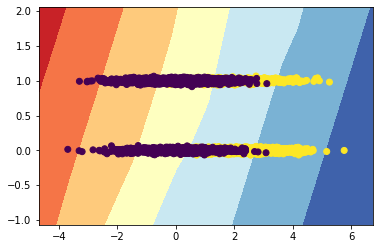

In [12]:
plot_decision(model_simple, x, y)

In [13]:
yh = model_simple(x).detach().argmax(-1).cpu().numpy()
np.mean(yh==y.cpu().numpy())

0.8655

In [14]:
batch_size = 128

dataset = TensorDataset(x.float(), y.long(), s.long())
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [15]:
fair_epochs = 20
epochs = 100

In [16]:
model = MLP(2, [10, 10], 2)
train_fair_model(
    model,
    loader,
    sensitive_directions_,
    epochs,
    fair_epochs,
    2,
    eps=0.2,
    lmbd_init=20.0,
    device="cpu",
)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:37<00:00,  2.70it/s]


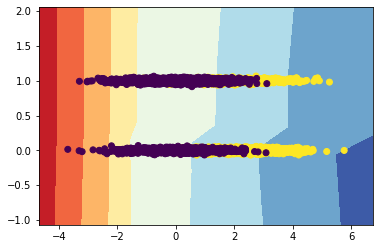

In [17]:
plot_decision(model, x, y)

In [18]:
yh = model(x).detach().argmax(-1).cpu().numpy()
np.mean(yh==y.cpu().numpy())

0.8636666666666667